# **Róbert Šafár** & **Matúš Totcimak**
## 3. fáza: *Strojové učenie*
#### Dataset 82
#### Podiel práce 50:50
#
#

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)

## Načítanie CSV súborov

In [2]:
con = pd.read_csv("dataset82/connections.csv", sep='\t')
proc = pd.read_csv("dataset82/processes.csv", sep='\t')

## Vstupné dáta v tejto fáze sú 'raw' dáta, preto vykonáme potrebné predspracovanie dát rovnako ako vo fáze 2.

### Pred spojením `Connections` a `Processes` odstránime duplikátne záznamy.

In [3]:
con = con.loc[~con.duplicated()].reset_index(drop=True).copy()
proc = proc.loc[~proc.duplicated()].reset_index(drop=True).copy()

### Spojenie `Connections` a `Processes`.

In [4]:
original = pd.merge(con, proc, on=['ts', 'imei', 'mwra'])

### Overenie chýbajúcich hodnôt. Z `EDA` už vieme, že žiadne nie sú.

In [5]:
original.isna().sum()[original.isna().sum() > 0]

Series([], dtype: int64)

### Vymažeme atribút `imei`, pretože ho nepovažujeme za atribút, ktorý by určoval hodnotu `mwra`. Je to len identifikátor zariadení. Takisto aj `ts`.

In [6]:
original = original.drop(columns=['ts', 'imei'])

In [7]:
class OutlierDetection(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.original_columns = X.columns.tolist()
        self.thresholds_ = {}
        for col in X.columns:
            if col == 'c.updateassist' or col == 'mwra':
                continue
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.thresholds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()

        X_transformed = X_transformed[X_transformed['c.updateassist'] <= 5]

        for col, (lower_bound, upper_bound) in self.thresholds_.items():
            if col == 'c.updateassist' or col == 'mwra':
                continue
            X_transformed[col] = np.where(X_transformed[col] < lower_bound, lower_bound, X_transformed[col])
            X_transformed[col] = np.where(X_transformed[col] > upper_bound, upper_bound, X_transformed[col])

        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return np.array(self.original_columns)

#
### Aplikujeme Transformácie: `Yeo-Johnson`, na atribúty, ktoré sa podobajú na normálnu distribúciu a `Quantile`, na atribúty s uniformnou distribúciou, respektíve s nie-normálnou distribúciou, s cieľom získať normálne rozdelenie pre všetky atribúty.
### Aplikujeme Škálovanie: `MinMax` pre jednotné rozsahy všetkých atribútov.

In [8]:
yeo_johnson_columns = ['c.dogalize', 'c.android.chrome', 'c.katana', 'c.android.gm',
                       'c.android.youtube', 'c.android.vending',
                       'p.android.packageinstaller', 'p.android.externalstorage', 'p.system',
                       'p.android.settings', 'p.android.documentsui', 'p.android.gm', 'p.katana',
                       'p.google', 'p.android.gms', 'p.inputmethod.latin']

quantile_columns = ['c.updateassist', 'c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider', 'p.android.chrome', 'p.process.gapps',
                    'p.olauncher', 'p.browser.provider', 'p.notifier', 'p.gms.persistent',
                    'p.android.defcontainer', 'p.android.vending', 'p.simulator', 'p.dogalize']


transformer = ColumnTransformer(
    transformers=[
        ('yeo_johnson', PowerTransformer(method='yeo-johnson'), yeo_johnson_columns),
        ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

minmax_scaler = MinMaxScaler()

pipeline = Pipeline(
    steps=[
        ('outliers', OutlierDetection()),
        ('transformer', transformer),
        ('scaler', minmax_scaler)
    ]
)

transformed_data = pipeline.fit_transform(original)
df = pd.DataFrame(transformed_data, columns=pipeline.get_feature_names_out())


### `Funkcia:` Vykreslenie `KDE` grafov pre `DF`.

In [9]:
def show_kde_graphs(df, attributes):
    num_attributes = len(attributes)

    if num_attributes == 0:
        print("No attributes to show")
        return
    
    cols = min(5, num_attributes)
    rows = math.ceil(num_attributes / cols)
    
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, column in enumerate(attributes):
        plt.subplot(rows, cols, i + 1)
        sns.kdeplot(df[column], fill=True, color='blue', alpha=0.5)
        plt.title(column)
        plt.xlabel('Hodnoty')
        plt.ylabel('Hustota')

    plt.tight_layout()
    plt.show()

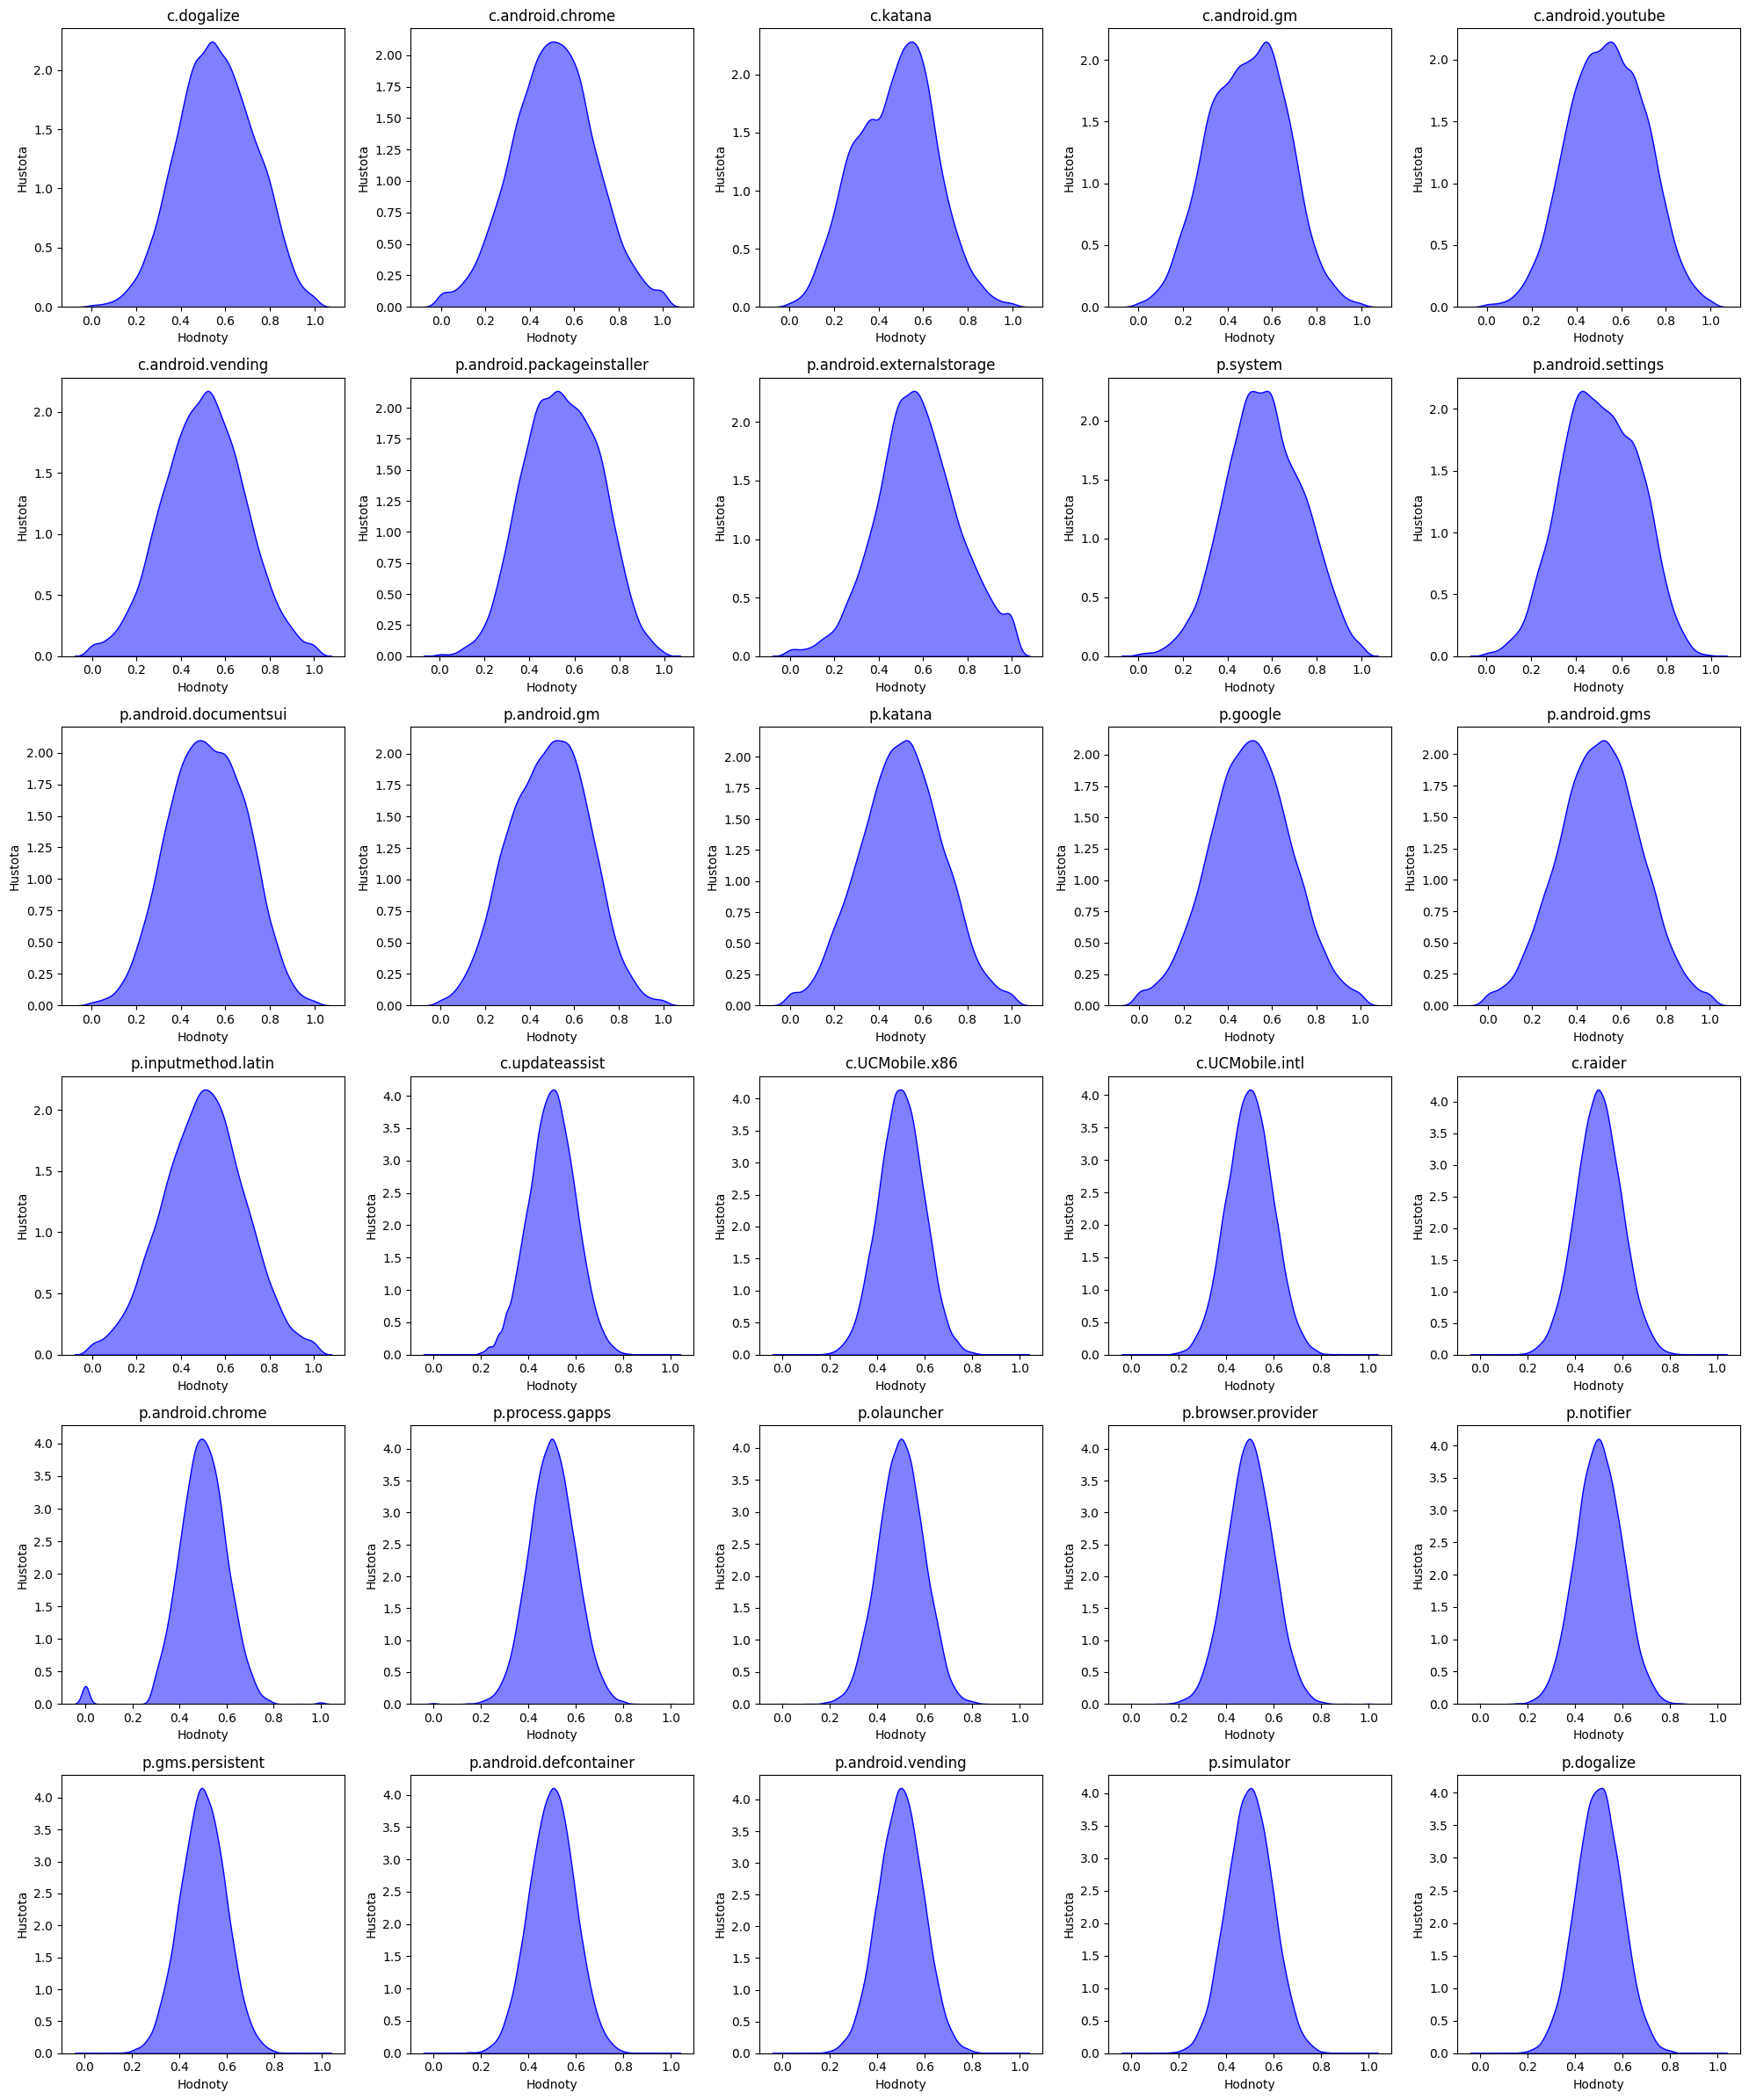

In [10]:
show_kde_graphs(df=df, attributes=df.drop(columns="mwra").columns)

### Môžeme vidieť, že najmä `Quantile` transformácia veľmi pomohla k normálemu rozdeleniu atribútov s predtým hlavne uniformnou distribúciou.

#
### DataFrame rozdelíme na `data` a `target`.

In [11]:
# Data
X = df.drop(columns=['mwra'])

# Target
y = df[['mwra']]

### Na výber najlepších `features` použijeme metódu `ANNOVA`, na základe fázy 2.

In [12]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit_transform(X, y.values.ravel())
names = X.columns[selector.get_support()]
X = X[names]
X.shape

(14961, 10)

### Pomer rozdelenia ponecháme `80:20` ako vo fáze 2.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

#
# **3.1 Jednoduchý klasifikátor na základe závislosti v dátach**

#
## *A) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň).*

### Reprezentácia jedného uzla v ID3 klasifikátore.

In [14]:
class Node:
    def __init__(self, attribute=None, value=None, lchild=None, rchild=None, pclass=None):
        self.attribute=attribute
        self.value=value
        self.lchild=lchild
        self.rchild=rchild
        self.pclass=pclass

### Naša implementácia ID3 stromu.

In [15]:
class ID3:
    def __init__(self, max_depth=2):
        self.root = None
        self.max_depth = max_depth

    #funkcia ktorá sa rekurzívne volá aby postavila strom
    def build_tree(self, data, curr_depth):
        nrows, nfeatures = data.shape
        nfeatures -=1
        y = data.iloc[:, -1]

        y_count = Counter(y)
        if curr_depth>self.max_depth or 0 not in y_count or 1 not in y_count:
            most_common_class = max(y_count, key=y_count.get)
            return Node(pclass=most_common_class)
        
        
        best_gain = 0
        total_lenght = len(y)
        split_index=0
        prev_value=0
        ldata_mask = []
        rdata_mask = []
        for attribute in data.columns[:-1]:
            sorted_values = data[attribute].sort_values()
            l_count = Counter({0.0:0, 1.0:0})
            r_count = Counter(y)


            attribute_entropy = self.entropy(r_count)

            values = sorted_values.values
            indexes = sorted_values.index
            for i in range(total_lenght-1):
                predicted_value = y[indexes[i]]
                l_count[predicted_value]+=1
                r_count[predicted_value]-=1

                if i > 0 and values[i] == values[i+1]:
                    continue


                if r_count.total()==0:
                    continue
                l_weight = l_count.total()/total_lenght
                info_gain = attribute_entropy - l_weight*self.entropy(l_count) - (1-l_weight)*self.entropy(r_count)
                if info_gain > best_gain:
                    ldata_mask = data[attribute].to_numpy() <= values[i]
                    rdata_mask = ~ldata_mask
                    best_attribute = attribute
                    best_value = values[i]
                    best_gain = info_gain
            

        if best_gain > 0:
            lbranch = data[ldata_mask]
            rbranch = data[rdata_mask]
            lchild = self.build_tree(lbranch, curr_depth+1)
            rchild = self.build_tree(rbranch, curr_depth+1)
            return Node(attribute=best_attribute, value=best_value, lchild=lchild, rchild=rchild)
        
        most_common_class = max(y_count, key=y_count.get)
        return Node(pclass=most_common_class)
    

    def entropy(self, counts):
        lenght = counts.total()
        probabilities = np.array([counts[0], counts[1]]) / lenght
        entropy = -np.sum(probabilities * np.log2(probabilities, where=probabilities > 0))
        return entropy
    
    def fit(self, X, y):
        self.root = self.build_tree(pd.concat([X, y], axis=1), 0)
        return self
        
    def predict(self, X):
        ret_val = []
        for row_index in range(X.shape[0]):
            row = X.iloc[row_index]
            node = self.root
            while node.pclass is None:
                if row[node.attribute] <= node.value:
                    node = node.lchild
                else:
                    node = node.rchild
            ret_val.append(node.pclass)
        return ret_val

### Strom sa v každej hĺbke rozdelí na 2 časti podľa podmienky, ktorý dáva najlepší `information gain`, ktorý získame podľa `entropie`.

#
## *B) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.*

### `Funkcia:` Porovnanie metrík `accuracy`, `precision`, `recall` pre rôzne hĺbky modelu.

In [16]:
def fit_predict(model, X_train, X_test, y_train, y_test, options):
    m = None
    results = {"Depth": [], "Accuracy (Train)": [], "Accuracy (Test)": [],
               "Precision (Train)": [], "Precision (Test)": [],
               "Recall (Train)": [], "Recall (Test)": []}
    
    for option in options:
        if model == "id3":
            m = ID3(max_depth=option)
        elif model == "random":
            m = RandomForestClassifier(max_depth=option)
        elif model == "knn":
            m = KNeighborsClassifier(n_neighbors=option)
        
        m.fit(X=X_train, y=y_train)

        m_train = m.predict(X=X_train)
        m_test = m.predict(X=X_test)

        train_accuracy = accuracy_score(y_train, m_train)
        test_accuracy = accuracy_score(y_test, m_test)
        train_precision = precision_score(y_train, m_train)
        test_precision = precision_score(y_test, m_test)
        train_recall = recall_score(y_train, m_train)
        test_recall = recall_score(y_test, m_test)

        results["Depth"].append(option)
        results["Accuracy (Train)"].append(train_accuracy)
        results["Accuracy (Test)"].append(test_accuracy)
        results["Precision (Train)"].append(train_precision)
        results["Precision (Test)"].append(test_precision)
        results["Recall (Train)"].append(train_recall)
        results["Recall (Test)"].append(test_recall)

    return pd.DataFrame(results)
    

### Získanie hodnôt `accuracy, precision, recall` nášho `ID3` klasifikátora pre rôzne `depths`.

In [17]:
id3_metrics = fit_predict(model="id3", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, options=[4,8,12])

### Porovnanie `ID3` hodnôt z metrík na trénovacích aj testovacích dátach.

In [18]:
print(id3_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
     4          0.895555         0.877381           0.907592          0.894246        0.927253       0.913665
     8          0.927724         0.881390           0.925821          0.892875        0.961353       0.922669
    12          0.950368         0.869362           0.942758          0.884833        0.980075       0.911547


### Presnosť sa do určitého bodu zvyšuje a následne začne klesať. Toto sa deje následkom `overfittingu` modelu.

#
## *C) Zistite či Váš ID3 klasifikátor má overfit.*

### Z výsledkov z časti `B)` vidíme, že presnosť na trénovacích a testovacích dátach pri hĺbke 8 sa líši v priemere o menej ako 4%, a preto môžeme usúdiť, že náš model pri hĺbke 8 nemá overfit.

#
# **3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia**

#
## *A) Na trénovanie využite jeden stromový algoritmus v scikit-learn.*

### Rozhodli sme sa použiť `RandomForest` a porovnať metriky pre rôzne hĺbky stromu.

In [19]:
random_forest_metrics = fit_predict(model="random", X_train=X_train, X_test=X_test,
                                                    y_train=y_train.values.ravel(), y_test=y_test.values.ravel(),
                                                    options=[4,8,12])

### Porovnanie `RandomForest` hodnôt z metrík na trénovacích aj testovacích dátach.

In [20]:
print(random_forest_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
     4          0.900902         0.887070           0.911242          0.904067        0.932201       0.918432
     8          0.921624         0.903775           0.925117          0.916233        0.951591       0.932733
    12          0.939088         0.906782           0.935251          0.917055        0.969644       0.936970


### Zo zvyšujúcou sa hĺbkou presnosť stúpa. Môžeme však vidieť že nárast presnosti je postupne menší.

#
## *B) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.*

### Rozhodli sme sa použiť `k-Nearest Neighbors` a a porovnať metriky pre rôzny počet susedov.

In [21]:
knn_metrics = fit_predict(model="knn", X_train=X_train, X_test=X_test,
                                       y_train=y_train.values.ravel(), y_test=y_test.values.ravel(),
                                       options=[5,10,15])

### Porovnanie `k-Nearest Neighbors` hodnôt z metrík na trénovacích aj testovacích dátach.

In [22]:
print(knn_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
     5          0.922878         0.910792           0.926147          0.917999        0.952527       0.942797
    10          0.920037         0.911460           0.923937          0.918947        0.950254       0.942797
    15          0.920287         0.910792           0.923636          0.918431        0.951056       0.942267


### Počet susedov nerobí veľké odchýlky na metrikách. Pri vyššom počte susedov sa presnosť jemne znižuje.

### Ak porovnáme jednotlivé metriky `RandomForest` s `kNN` tak vidíme, že `Accuracy` je o približne 0.7% vyššia pre `kNN`. Rozdiel v `Precision` je 0.3%, pre `Recall` je 1%, obidva  v prospech `kNN`.

#
## *C) Porovnajte výsledky s ID3 z prvého kroku.*

### `ID3` - `RandomForest`
#### Náš ID3 dosahuje v priemere horšie výsledky a pri hĺbke 12 už overfittuje. Na druhej strane metriky pre RandomForest neklesajú a rozdiely medzi trénovacimi a testovacími dátami sú menšie.
### `ID3` - `kNN`
#### Náš ID3 dosahuje horšie výsledky ako kNN a takisto s väčšou hĺbkou začína overfittovať. Jednotlivé metriky pre kNN napriek zvyšujúcemu sa počtu susedov výrazne nestúpajú.

#
## *D) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus.*

### Vizualizácia `RandomForest` nášho modelu s hĺbkou 8.

In [23]:
alg = RandomForestClassifier(max_depth=8).fit(X=X_train, y=y_train.values.ravel())

### Pre prehľadnosť obmedzíme `max_depth` na 2.

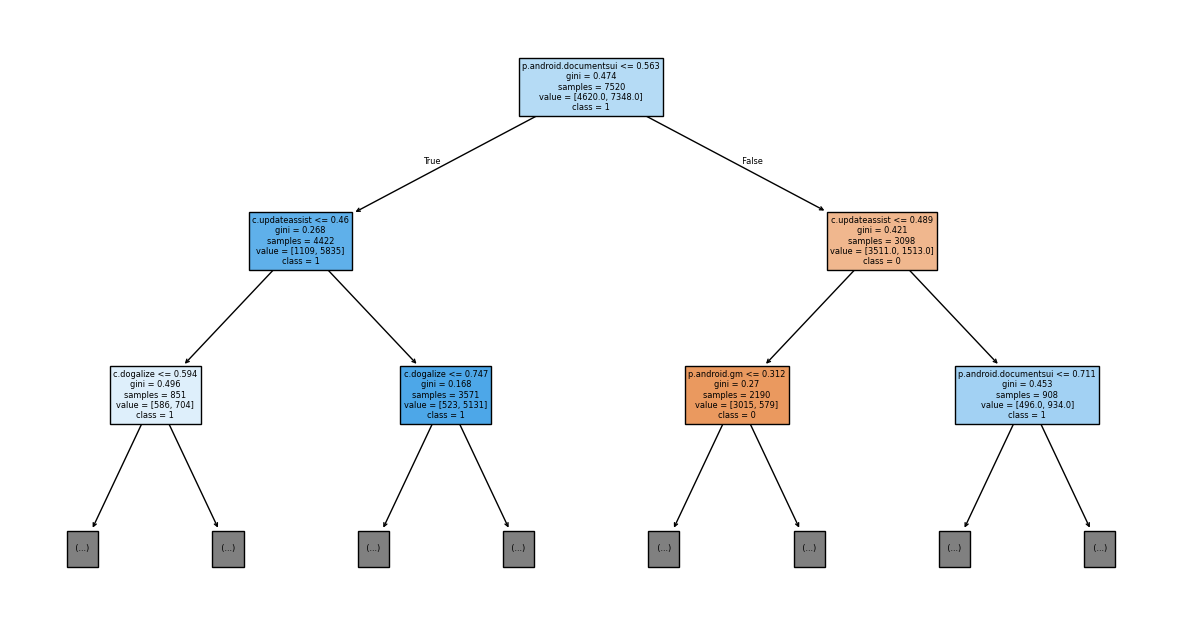

In [24]:
plt.figure(figsize=(15, 8))
plot_tree(alg.estimators_[0], feature_names=X.columns, class_names=['0', '1'], filled=True, max_depth=2)
plt.show()

### Vizualizácia `RandomForest` nášho modelu s neobmedzenou hĺbkou.

In [25]:
alg = RandomForestClassifier(max_depth=None).fit(X=X_train, y=y_train.values.ravel())

### Pre zobrazenie celého stromu `max_depth` neobmedzíme.

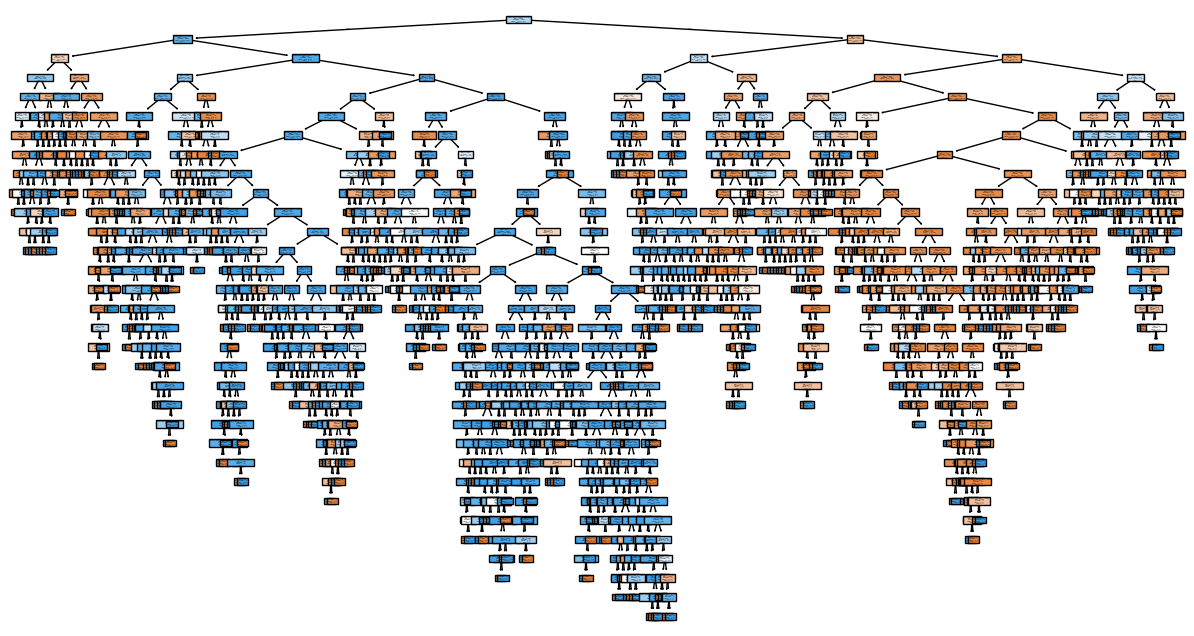

In [26]:
plt.figure(figsize=(15, 8))
plot_tree(alg.estimators_[0], feature_names=X.columns, class_names=['0', '1'], filled=True, max_depth=None)
plt.show()

#
## *E) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall.*

### Na porovnanie s našími aktuálnymi modelmi, na ktoré sme aplikovali: `OutlierRemoval`, `MinMaxScaler`, `PowerTransformer` a `QuantileTransformer` aplikovať aj iné kombinácie úprav dát, konkrétne:
#### **1.** `OutlierRemoval` neaplikujeme. Zvyšné úpravy ako aktuálne.
#### **2.** Aplikujeme iba `PowerTransformer`. Zvyšné úpravy ako aktuálne.
#### **3.** Aplikujeme iba `StandardScaler`. Zvyšné úpravy ako aktuálne.
### Tieto nové úravy dát aplikujeme na `RAW` dáta.


### Zadefinujeme `StandardScaler` škálovanie a `Yeo-Johson` transformáciu, ktoré aplikujeme pri úprave dát.

In [27]:
standard_scaler = StandardScaler()

yeo_johnson_transformer = ColumnTransformer(
    transformers=[
        ('yeo-johnson', PowerTransformer(method='yeo-johnson'), slice(1, 31))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

### `Funkcia:` Aplikovanie zvolenej `pipeline` na dáta.

In [28]:
def pipeline_options(option, data=None):
    pajplajn = None
    if data is None: return "CHYBAJUCE DATA"

    if option == "no_outliers":
        without_outliers = Pipeline(
            steps=[
                ('transformer', transformer),
                ('scaler', minmax_scaler)
            ]
        )
        pajplajn = without_outliers
    
    elif option == "only_yeo":
        normal_only_yeo = Pipeline(
            steps=[
                ('outliers', OutlierDetection()),
                ('transformer', yeo_johnson_transformer),
                ('scaler', minmax_scaler)
            ]
        )
        pajplajn = normal_only_yeo
    
    elif option == "only_standard":
        normal_standard_on_all = Pipeline(
            steps=[
                ('outliers', OutlierDetection()),
                ('transformer', transformer),
                ('scaler', standard_scaler)
                
            ]
        )
        pajplajn = normal_standard_on_all

    if pajplajn is None:
        print("ZLE PARAMETRE")
        return

    transformed_data = pajplajn.fit_transform(data)
    df = pd.DataFrame(transformed_data, columns=pajplajn.get_feature_names_out())


    # Data
    X = df.drop(columns=['mwra'])

    # Target
    y = df[['mwra']]

    selector = SelectKBest(score_func=f_classif, k=10)
    selector.fit_transform(X, y.values.ravel())
    names = X.columns[selector.get_support()]
    X = X[names]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)
    
    return df, X_train, X_test, y_train, y_test


### Úpravy č. **`1`** - `OutlierRemoval` neaplikujeme.

In [29]:
df_outliers, X_outliers_train, X_outliers_test, y_outliers_train, y_outliers_test = pipeline_options(option="no_outliers", data=original)

### Úpravy č. **`2`** - Aplikujeme iba `PowerTransformer`.

In [30]:
df_yeo, X_yeo_train, X_yeo_test, y_yeo_train, y_yeo_test = pipeline_options(option="only_yeo", data=original)

### Úpravy č. **`3`** - Aplikujeme iba `StandardScaler`.

In [31]:
df_standard, X_standard_train, X_standard_test, y_standard_train, y_standard_test = pipeline_options(option="only_standard", data=original)

#
### `RandomForest`

### Pre `RandomForest` budeme brať do úvahy iba `max_depth` = 8.

#### Model s úpravami č. **`1`**

In [32]:
random_forest_1_metrics = fit_predict(model="random",
                                      X_train=X_outliers_train, X_test=X_outliers_test,
                                      y_train=y_outliers_train.values.ravel(), y_test=y_outliers_test.values.ravel(),
                                      options=[8])

print(random_forest_1_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
     8          0.919573         0.915916           0.923455          0.924607        0.950492       0.942369


#### Model s úpravami č. **`2`**

In [33]:
random_forest_2_metrics = fit_predict(model="random",
                                      X_train=X_yeo_train, X_test=X_yeo_test,
                                      y_train=y_yeo_train.values.ravel(), y_test=y_yeo_test.values.ravel(),
                                      options=[8])

print(random_forest_2_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
     8          0.921624         0.902773           0.925006          0.915237        0.951725       0.932203


#### Model s úpravami č. **`3`**

In [34]:
random_forest_3_metrics = fit_predict(model="random",
                                      X_train=X_standard_train, X_test=X_standard_test,
                                      y_train=y_yeo_train.values.ravel(), y_test=y_yeo_test.values.ravel(),
                                      options=[8])

print(random_forest_3_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
     8          0.922042         0.903775           0.925497          0.916233        0.951859       0.932733


### Z výsledkov pre `RandomForest` vidíme, že najlepší model je prvý, respektíve ten, v ktorom sme ponechali outlierov a používali dá sa povedať `RAW` dáta. Takisto tento model dosahuje lepšie výsledky ako náš model s pôvodnou úpravou dát.

#
### `kNN`

### Pre `kNN` budeme brať do úvahy iba `n_neighbours` = 10.

#### Model s úpravami č. **`1`**

In [35]:
knn_1_metrics = fit_predict(model="knn",
                            X_train=X_outliers_train, X_test=X_outliers_test,
                            y_train=y_outliers_train.values.ravel(), y_test=y_outliers_test.values.ravel(),
                            options=[10])

print(knn_1_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
    10          0.917904         0.919586           0.922053          0.926371        0.949295       0.946638


#### Model s úpravami č. **`2`**

In [36]:
knn_2_metrics = fit_predict(model="knn",
                            X_train=X_yeo_train, X_test=X_yeo_test,
                            y_train=y_yeo_train.values.ravel(), y_test=y_yeo_test.values.ravel(),
                            options=[10])

print(knn_2_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
    10          0.920705         0.910458           0.924126          0.918388         0.95119       0.941737


#### Model s úpravami č. **`3`**

In [37]:
knn_3_metrics = fit_predict(model="knn",
                            X_train=X_standard_train, X_test=X_standard_test,
                            y_train=y_yeo_train.values.ravel(), y_test=y_yeo_test.values.ravel(),
                            options=[10])

print(knn_3_metrics.to_string(index=False))

 Depth  Accuracy (Train)  Accuracy (Test)  Precision (Train)  Precision (Test)  Recall (Train)  Recall (Test)
    10          0.920455         0.911794           0.924317          0.919855        0.950522       0.942267


### Z výsledkov pre `kNN` vidíme, že rovnako ako pri `RandomForest`, najlepší model je prvý, respektíve ten, v ktorom sme ponechali outlierov a používali dá sa povedať `RAW` dáta. Takisto tento model dosahuje lepšie výsledky ako náš model s pôvodnou úpravou dát.

#
# **3.3 Optimalizácia alias hyperparameter tuning**

#
## *A) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).*

### Nastavenia hyperparametrov vyskúšame na našom pôvodnom `RandomForest` modeli.

In [ ]:
grid_param = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 8, 12, 16],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=grid_param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train.values.ravel())

print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Score:", grid_result.best_score_)

#
## *B) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).*

### Použili sme `StackingClassifier`, ktorý kombinuje predikcie viacerých modelov (`RandomForest`, `kNN`, `SVC`) na zvýšenie presnosti predikcie.

In [ ]:
level0 = [
    ('random_forest', RandomForestClassifier(max_depth=8, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
    ('svc', SVC(kernel='linear', probability=True, random_state=42))
]

level1 = LogisticRegression()

stacking_model = StackingClassifier(estimators=level0, final_estimator=level1)

stacking_model.fit(X_train, y_train.values.ravel())

y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Stacking Model: {accuracy}")

### Použili sme `BaggingClassifier`, na natrénovanie modelov `RandomForestClassifier` a získanie jeho presnosti.

In [ ]:
bagging = BaggingClassifier(estimator=RandomForestClassifier(max_depth=8, random_state=42), random_state=42)
bagging.fit(X_train, y_train.values.ravel())
print(f"Bagging score: {bagging.score(X_test, y_test)}")

#
## *C) Využite krížovú validáciu (cross validation) na trénovacej množine.*

### Použili sme `StratifiedKFold` a ako estimator `RandomForestClassifier`.

In [ ]:
cv = StratifiedKFold(shuffle=True, random_state=42)
scores = cross_val_score(estimator=RandomForestClassifier(max_depth=8, random_state=42),
                            X=X_train, y=y_train.values.ravel(), cv=cv, scoring='accuracy')

print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

#
## *D) Dokážte že Váš nastavený najlepší model je bez overfitingu.*

### Náš najlepšie nastavený model (`RandomForest`) je z časti `3.2 A)` s nasledovnými nastaveniami.

In [43]:
cls = RandomForestClassifier(n_estimators=150, max_depth=16, min_samples_leaf=1, min_samples_split=10)
cls.fit(X=X_train, y=y_train.values.ravel())

Strain = cls.predict(X=X_train)
Stest = cls.predict(X=X_test)

### Výpis metrík modelu.

In [45]:
print("=== Model Evaluation Metrics ===\n")
print(f"ACCURACY:")
print(f"  Training: {accuracy_score(y_train, Strain):.4f}")
print(f"  Testing : {accuracy_score(y_test, Stest):.4f}\n")

print(f"PRECISION:")
print(f"  Training: {precision_score(y_train, Strain):.4f}")
print(f"  Testing : {precision_score(y_test, Stest):.4f}\n")

print(f"RECALL:")
print(f"  Training: {recall_score(y_train, Strain):.4f}")
print(f"  Testing : {recall_score(y_test, Stest):.4f}")

=== Model Evaluation Metrics ===

ACCURACY:
  Training: 0.9319
  Testing : 0.9085

PRECISION:
  Training: 0.9301
  Testing : 0.9173

RECALL:
  Training: 0.9634
  Testing : 0.9396


### Konštantujeme, že na základe rozdielov presnosti medzi trénovacími a testovacími dátami nedochádza k overfittingu. Priemerný rozdiel je menej ako `3%`.

#
# **3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu**

#
## *A) Stratégie riešenia chýbajúcich hodnôt a outlierov.*

### Chýbajúce hodnoty sme neriešili, pretože žiadne v datasete neboli.
### Outlierov sme odstraňovali rovnako ako v predošlých fázach, metódou `IQR`. V časti `3.2 E)`, kde sme testovali viaceré kombinácie úpravy dát, nám z výsledkov vyplýva, že práve ponechanie outlierov v datasete viedlo k najlepším výsledkom modelu. Konkrétne napr. rozdiel presnosti pre `RandomForest` ak sme outlierov ponechali je približne `1%` a pre `kNN` je `0.7%`.

#
## *B) Dátová transformácia (scaling, transformer, ...).*

### Používali sme 2 škálovania. Viac `MinMaxScaler` ako `StandardScaler`. Po porovnaní presnosti modelov (jeden s `MinmaxScaler`, druhý so `StandardScaler`), v ktorých sme takisto odstraňovali outlierov a použili `Yeo-Johnson` a `Quantile` transformáciu na rôzne atribúty, sme zistili, že rozdiely sú maximálne `0.2%`, čo nehrá signifikantnú rolu.

#
## *C) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning.*

### Na výber atribútov, tzv. `Feature selection`, sme použili `ANNOVA selection`, ktorý nám najlepšie sedel z predošlej fázy.
### Okrem nami naimplementovaného `ID3 klasifikátora ` sme používali `RandomForest` a `kNN` algoritmy. Ako lepši algoritmus nám vyšiel `kNN`, s presnosťou lepšou o približne `0.5%`.
### Na nájdenie najlepších nastavení parametrov pre model `RandomForest` v časti `3.3 A)` testovali spolu 48 rôznych nastavení pričom najlepšie nastavenie: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150} dalo presnosť `91.6%`, kdežto náš prvý model pre `RandomForest`, kde {'max_depth': 8'} dal presnosť takisto `91.6%`.
### `Ensemble learning` dosiahol skóre `90.4%`, čo je nižšie ako naše "štandardné" modely.

#
## *D) Ktorý model je Váš najlepší model pre nasadenie (deployment)?*

### Náš najlepší model je `kNN` s nasledujúcou úpravou dát:
- #### ponechanie outlierov
- #### kombinácia `Yeo-Johnson` a `Quantile` transformácií
- #### `MinMax` škálovanie
- #### `ANNOVA` feature selection

#
## *E) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?*

### Stĺpce, na ktoré sa aplikuje `Yeo-Johnson` transformácia.

```python
    [   'c.dogalize', 'c.android.chrome', 'c.katana', 'c.android.gm',
        'c.android.youtube', 'c.android.vending',
        'p.android.packageinstaller', 'p.android.externalstorage', 'p.system',
        'p.android.settings', 'p.android.documentsui', 'p.android.gm', 'p.katana',
        'p.google', 'p.android.gms', 'p.inputmethod.latin'
    ]

### Stĺpce, na ktoré sa aplikuje `Quantile` transformácia.

```python
    [
        'c.updateassist', 'c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider',
        'p.android.chrome', 'p.process.gapps', 'p.olauncher', 'p.browser.provider',
        'p.notifier', 'p.gms.persistent', 'p.android.defcontainer',
        'p.android.vending', 'p.simulator', 'p.dogalize'
    ]

### `Column transformer` na aplikovanie transformácií.

``` python
    transformer = ColumnTransformer(
        transformers=[
            ('yeo_johnson', PowerTransformer(method='yeo-johnson'), yeo_johnson_columns),
            ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

### `Pipeline` + `Feature selection` na aplikovanie všetkých úprav dát.

 ``` python
    pipeline = Pipeline(
        steps=[
            ('transformer', transformer),
            ('scaler', minmax_scaler)
        ]
    )

    annova = SelectKBest(score_func=f_classif, k=10)
    annova.fit_transform(X, y.values.ravel())